# Feature Engineering

In [1]:
# import basic libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import sidetable as stb
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get working directory 
import os, sys
sys.path.append(os.path.abspath('..'))

In [3]:
import scripts.feature_engineering as fe

In [4]:
# load data 
file_path = '../data/customers_data.csv'
df = fe.load_data(file_path)

In [5]:
# Data preview
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,76871,36123,3957,887,4406,UGX,256,6,10,airtime,3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0
1,73770,15642,4841,3829,4406,UGX,256,4,6,financial_services,2,-20.0,20,2018-11-15 02:19:08+00:00,2,0
2,26203,53941,4229,222,4683,UGX,256,6,1,airtime,3,500.0,500,2018-11-15 02:44:21+00:00,2,0
3,380,102363,648,2185,988,UGX,256,1,21,utility_bill,3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0
4,28195,38780,4841,3829,988,UGX,256,4,6,financial_services,2,-644.0,644,2018-11-15 03:34:21+00:00,2,0


### Create Aggregate Features

* Total Transaction Amount: Sum of all transaction amounts for each customer.
* Average Transaction Amount: Average transaction amount per customer.
* Transaction Count: Number of transactions per customer.
* Standard Deviation of Transaction Amounts: Variability of transaction amounts per customer.

In [6]:
aggregate_features = fe.aggregate_features(df)
# Merge Agregated features
df = df.merge(aggregate_features, on = 'AccountId', how = 'left')

# fill missing Value in StdAmount
df['StdAmount'] = df['StdAmount'].fillna(0)


### Extract Timely Feature

In [7]:
# Compute time-based features
df = fe.extract_time_features(df)
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,TransactionCount,StdAmount,MaxAmount,TransactionHour,TransactionDay,TransactionMonth,TransactionYear,TransactionDayOfWeek,IsWeekend,TimeSinceLastTransaction
0,76871,36123,3957,887,4406,UGX,256,6,10,airtime,...,66,3146.231284,20000.0,2,15,11,2018,3,0,0.000000
1,73770,15642,4841,3829,4406,UGX,256,4,6,financial_services,...,30893,1845.812752,50.0,2,15,11,2018,3,0,0.000000
2,26203,53941,4229,222,4683,UGX,256,6,1,airtime,...,2,0.000000,500.0,2,15,11,2018,3,0,0.000000
3,380,102363,648,2185,988,UGX,256,1,21,utility_bill,...,26,19707.241933,100000.0,3,15,11,2018,3,0,0.000000
4,28195,38780,4841,3829,988,UGX,256,4,6,financial_services,...,30893,1845.812752,50.0,3,15,11,2018,3,0,1.253611


### Convert Categorical Value into 

From the dataset, the categorical features are:

* ProductCategory (nominal: e.g., "airtime", "financial_services")
* CurrencyCode (nominal: "UGX")

In [8]:
df = pd.get_dummies(df, columns=['ProductCategory', 'CurrencyCode'], drop_first= True)
for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)

### Handle Missing Value

In [9]:
df.isnull().sum()

TransactionId                         0
BatchId                               0
AccountId                             0
SubscriptionId                        0
CustomerId                            0
CountryCode                           0
ProviderId                            0
ProductId                             0
ChannelId                             0
Amount                                0
Value                                 0
TransactionStartTime                  0
PricingStrategy                       0
FraudResult                           0
TotalAmount                           0
TotalDebits                           0
TotalCredits                          0
AvgAmount                             0
TransactionCount                      0
StdAmount                             0
MaxAmount                             0
TransactionHour                       0
TransactionDay                        0
TransactionMonth                      0
TransactionYear                       0


### Normalize Numerical Features

In [10]:
from sklearn.preprocessing import MinMaxScaler
# Features to standardize
numerical_features = ['Amount', 'Value', 'TotalDebits', 'TotalCredits', 
                      'AvgAmount', 'TransactionCount', 'StdAmount']

# Initialize scaler
minmax_scaler = MinMaxScaler()

# Apply normalization

df[numerical_features] = minmax_scaler.fit_transform(df[numerical_features])

# Display normalized results
print(df[['Amount', 'Value', 'TotalDebits']].head(3))

     Amount     Value  TotalDebits
0  0.092004  0.000101     0.001880
1  0.091910  0.000002     0.000001
2  0.091958  0.000050     0.000012


## Feature Analysis

In [11]:
# Frequency of FraudResult
df.stb.freq(['FraudResult'])

,FraudResult,count,percent,cumulative_count,cumulative_percent
0,0,95469,99.798248,95469,99.798248
1,1,193,0.201752,95662,100.000000


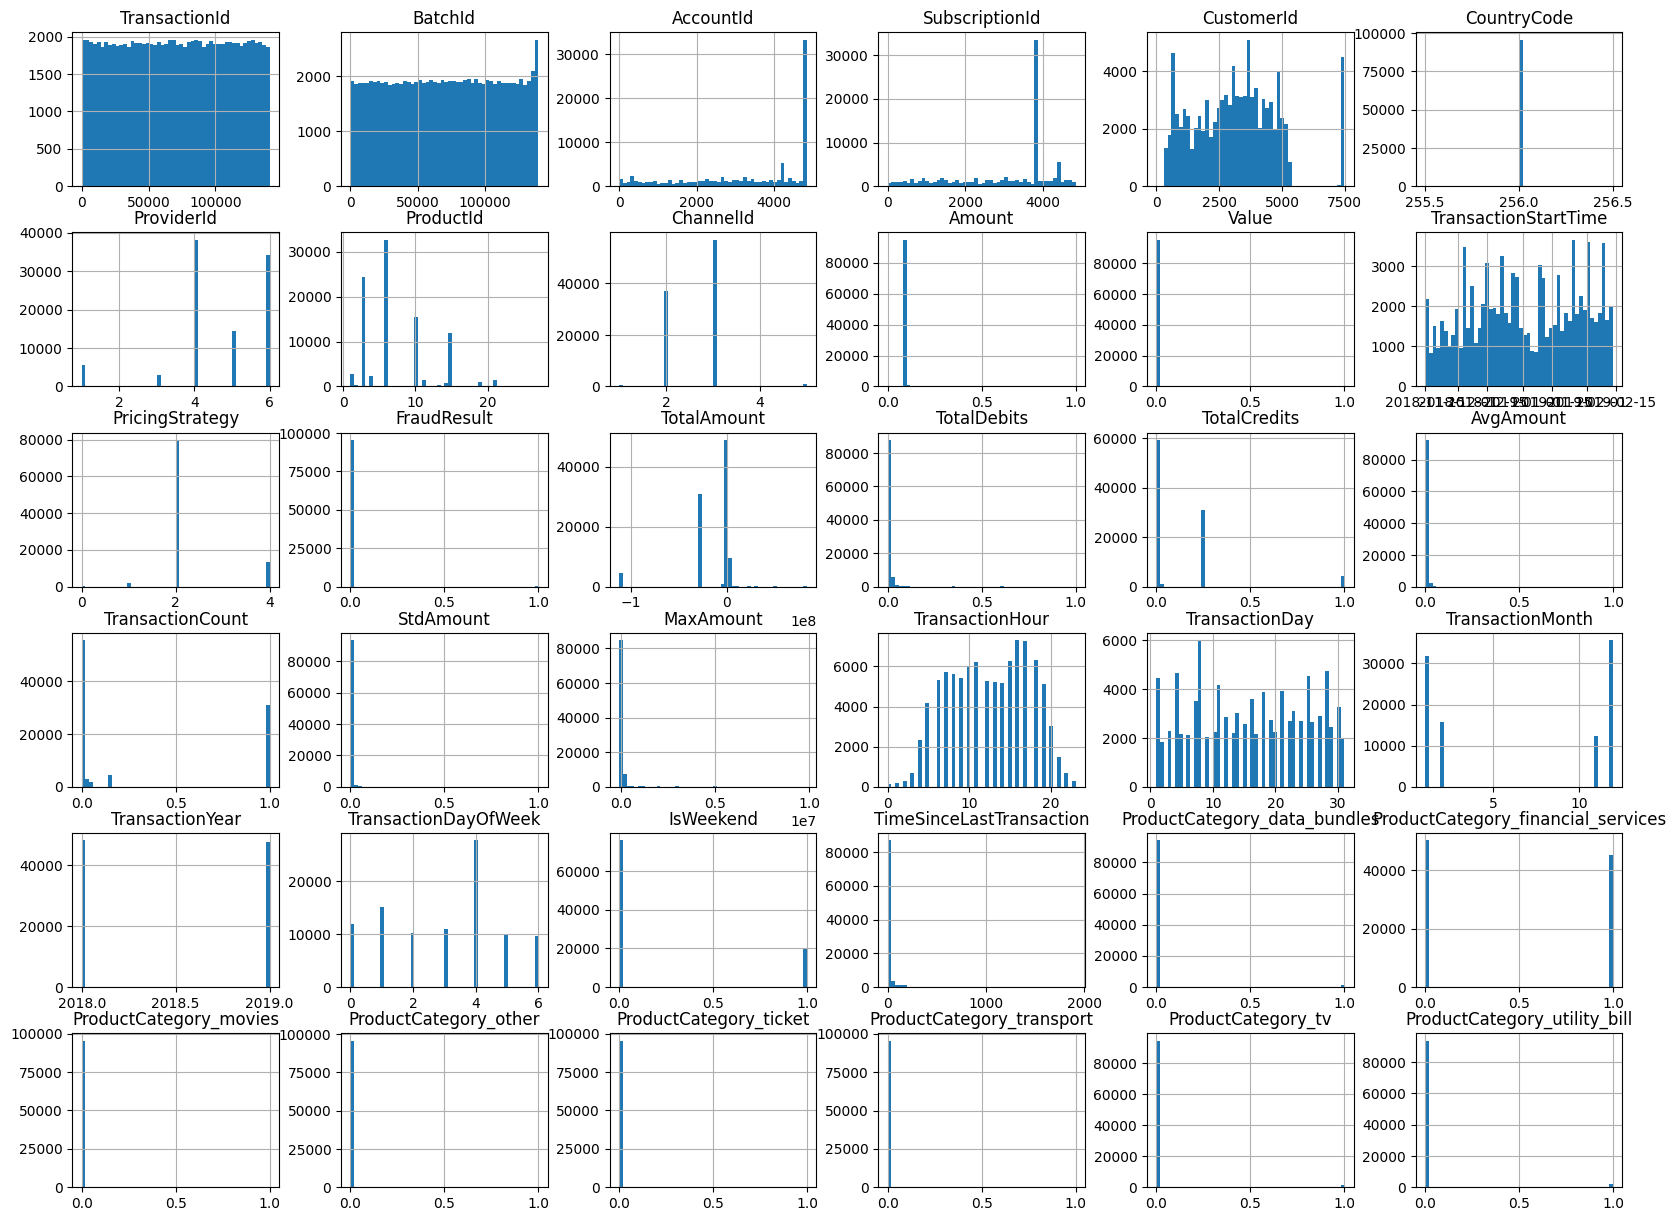

In [12]:
# distribution plots - Histograms
df.hist(figsize = (20, 15), bins = 50);

### Correlation Analysis

In [13]:
corr_matrix = df.corr()
corr_matrix

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CountryCode,ProviderId,ProductId,ChannelId,Amount,...,IsWeekend,TimeSinceLastTransaction,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill
TransactionId,1.000000,-0.006569,-0.004491,-0.001359,-0.003697,NaN,0.000931,0.001211,0.005245,-0.001785,...,0.003538,-0.000097,-0.004177,-0.001398,-0.003373,0.004841,0.000184,0.003960,0.001904,0.001194
BatchId,-0.006569,1.000000,0.031850,0.060558,0.144860,NaN,-0.034058,-0.017532,-0.063891,-0.013423,...,-0.032964,-0.014973,-0.007786,-0.053860,-0.005199,0.007645,0.001089,-0.002598,-0.007839,-0.001388
AccountId,-0.004491,0.031850,1.000000,0.352973,0.503405,NaN,-0.213127,-0.158946,-0.694218,-0.048580,...,-0.022940,-0.117524,-0.058176,0.513197,-0.027076,0.001071,-0.023673,-0.014340,-0.088464,-0.095605
SubscriptionId,-0.001359,0.060558,0.352973,1.000000,0.133708,NaN,-0.221204,-0.112645,-0.423540,-0.036190,...,-0.047744,-0.097356,-0.035991,0.311884,-0.021229,0.005583,-0.010483,-0.008792,-0.039375,-0.050072
CustomerId,-0.003697,0.144860,0.503405,0.133708,1.000000,NaN,-0.004948,-0.023494,-0.127159,-0.037375,...,-0.058192,-0.019558,0.008011,-0.113283,-0.007964,0.002889,-0.003861,-0.007429,-0.033574,-0.022485
CountryCode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProviderId,0.000931,-0.034058,-0.213127,-0.221204,-0.004948,NaN,1.000000,-0.180489,0.323558,-0.049208,...,0.061620,-0.027970,0.071205,-0.524404,-0.012148,-0.005789,-0.013451,-0.018492,0.061430,0.039305
ProductId,0.001211,-0.017532,-0.158946,-0.112645,-0.023494,NaN,-0.180489,1.000000,0.203787,0.089368,...,-0.027881,0.111242,0.063685,0.223040,0.152459,0.004499,0.128546,-0.008400,0.231866,0.381338
ChannelId,0.005245,-0.063891,-0.694218,-0.423540,-0.127159,NaN,0.323558,0.203787,1.000000,0.051903,...,0.043806,0.144893,0.105972,-0.588649,0.028940,0.003091,0.014809,0.010930,0.080648,0.103818
Amount,-0.001785,-0.013423,-0.048580,-0.036190,-0.037375,NaN,-0.049208,0.089368,0.051903,1.000000,...,0.003825,0.008258,-0.003521,0.036366,0.000353,-0.000231,0.034714,0.021441,0.009368,0.012204


In [14]:
df.head().T

,0,1,2,3,4
TransactionId,76871,73770,26203,380,28195
BatchId,36123,15642,53941,102363,38780
AccountId,3957,4841,4229,648,4841
SubscriptionId,887,3829,222,2185,3829
CustomerId,4406,4406,4683,988,988
CountryCode,256,256,256,256,256
ProviderId,6,4,6,1,4
ProductId,10,6,1,21,6
ChannelId,3,2,3,3,2
Amount,0.092004,0.09191,0.091958,0.09375,0.091853


# Drop Unneccessary Columns

In [15]:
# Drop identifier columns 
# Drop columns that are the same for all transactions (e.g. CountryCode)
# datetime (already has derived features)
df.drop(columns=[
    'TransactionId', 'BatchId', 'AccountId', 
    'SubscriptionId', 'CustomerId', 'TransactionStartTime', 
     'CountryCode'
], inplace=True)

# Save Feature Engineered Data

In [17]:
df.to_csv('../data/processed_data.csv', index = False)